# Matching Exercise

In this exercise, we’ll be evaluating how getting a college degree impacts earnings in the US using matching.

# Data Setup

In [10]:
import pandas as pd
import numpy as np

df = pd.read_stata(
    "./data/cps_for_matching.dta"
)

df.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit"
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit"
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated"
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit"
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"


# Getting To Know Your Data
Before you start matching, it is important to examine your data to ensure that matching is feasible (you have some overlap the the features of people in the treated and untreated groups), and also that there is a reason to match: either you’re unsure about some of the functional forms at play, or your have some imbalance between the two groups.

## Exercise 1
Show the raw difference of annual_earnings between those with and without a college degree (has_college). Is the difference statistically significant?

In [11]:
cps[cps['annual_earnings'].isnull() == False].head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"
5,14438,31200.0,0,2.0,0,34,0-NV,"Private, For Profit"
7,108334,20020.0,0,0.0,1,68,0-GA,"Private, For Profit"
8,249989,22859.2,0,0.0,0,46,0-VT,Government - Local
9,64886,73860.8,0,0.0,1,38,0-MT,"Private, For Profit"


In [15]:
from scipy.stats import ttest_ind

dfn = df[df['annual_earnings'].isnull() == False]

# Compare
college    =  dfn[dfn['has_college']==1 ]["annual_earnings"].mean()
nocollege =  dfn[dfn['has_college']==0]["annual_earnings"].mean()

t_test = ttest_ind(dfn[dfn['has_college']==1 ]["annual_earnings"],
                   dfn[dfn['has_college']==0]["annual_earnings"])

print("Annual earnings with college degree: {:.2f}".format(college))
print("Annual earnings without college degree: {:.2f}".format(nocollege))
print("Difference between genders : {:.2f}".format(college-nocollege))
print("P-value : {:.4f}".format(t_test[1]))

Annual earnings with college degree: 53024.16
Annual earnings without college degree: 38865.67
Difference between genders : 14158.50
P-value : 0.0000


**Answer:** The annual salary with a college degree is 53024 dollars, while the annual salary without a college degree is 38865. The difference is about 14158 dollars. According to the p-value of the t-test, the difference is significant. 

# Exercise 2
Next we can check for balance. Check the share of people in different racial groups who have college degrees. Are those differences statistically significant?

Does the distribution also look different across counties (I don’t need statistical significance for this)?

Does the data seem balanced?

In [130]:
college_data_dic = {
    "college" : df.groupby(["simplified_race"])["has_college"].sum(),
    "total" : df.groupby(["simplified_race"]).size()
}

df_share=pd.DataFrame(data=college_data_dic)

df_share["share"] = df_share.college/df_share.total

df_share.head()

,college,total,share
simplified_race,,,
0.0,3340,7622,0.438205
1.0,324,1020,0.317647
2.0,300,1512,0.198413
3.0,473,996,0.474900


In [131]:
country_data_dic = {
    "college" : df.groupby(["county"])["has_college"].sum(),
    "total" : df.groupby(["county"]).size()
}

df_share=pd.DataFrame(data=country_data_dic)

df_share["share"] = df_share.college/df_share.total

df_share.head(n=10)

,college,total,share
county,,,
0-AK,43,133,0.323308
0-AL,59,175,0.337143
0-AR,51,171,0.298246
0-AZ,5,7,0.714286
0-CA,87,220,0.395455
0-CO,51,89,0.573034
0-CT,16,33,0.484848
0-FL,40,102,0.392157
0-GA,90,207,0.434783


# Question :  
- Do we need provide T-Test for share difference between the 4 race group ?

**Answer:**  
- The college shares across different races are quite different, especially for race 2. Race 2's college rate is lower than three other race groups.
- The college shares across the different countries are quite additional too. For example, the country of 0-AZ owns a pretty high college rate. 
- The data is not balanced for the two metrics.

# Exercise 3
One of the other advantages of matching is that even when you have balanced data, you don’t have to go through the process of testing out different functional forms to see what fits the data base.

In our last exercise, we looked at the relationship between gender and earnings “controlling for age”, where we just put in age as a linear control. Plot a non-linear regression of annual_earnings on age (if you’re using plotnine, use geom_smooth(method="lowess").

Does the relationship look linear?

Does this speak to why it’s nice to not have to think about functional forms with matching as much?

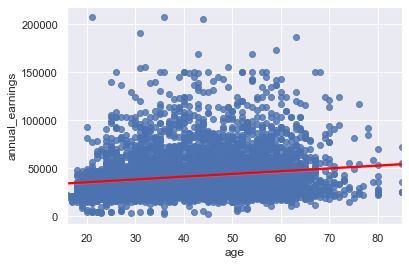

In [47]:
import seaborn as sns; sns.set_theme(color_codes=True)
 
ax = sns.regplot(x="age", y="annual_earnings", data=dfn,
                 line_kws={"color": "red"})

# Question :  
- Plot a non-linear regression of annual_earnings on age ? What mean of non=linear

# Matching!
Because DAME is an implementation of exact matching, we have to discretize all of our continuous variables. Thankfully, in this case we only have age, so this shouldn’t be too hard!

# Exercise 4
Create a new variable that discretizes age into a single value for each decade of age.

Because CPS only has employment data on people 18 or over, though, include people who are 18 or 19 with the 20 year olds so that group isn’t too small, and if you see any other really small groups, please merge those too.

In [122]:
df["age2"] = 2 
df["age2"] = np.array(df.age >= 30) + np.array(df.age2)
df["age2"] = np.array(df.age >= 40) + np.array(df.age2)
df["age2"] = np.array(df.age >= 50) + np.array(df.age2)
df["age2"] = np.array(df.age >= 60) + np.array(df.age2)
df.groupby(["age2"]).size()

age2
2    1990
3    2760
4    2551
5    2397
6    1452
dtype: int64

All the ages were discretizes into 5 bins whose lable means:
- 2: age < 30
- 3: age < 40
- 4: age < 50
- 5: age < 60
- 6: age >= 60

**Note**
- People whose age below 20 are combined with people younger than 30 to avoid too small groups. 
- For the same reason, people who are older than 60 were grouped without further division.

# Exercise 5
We also have to covert our string variables into numeric variables for DAME, so convert county and class94 to a numeric vector of intergers.

(Note: it’s not clear whether class94 belongs: if it reflects people choosing fields based on passion, it belongs; if people choose certain jobs because of their degrees, its not something we’d actually want in our regression.

Hint: if you use pd.Categorical to convert you var to a categorical, you can pull the underlying integer codes with .codes.

In [135]:
df["country_c"] = pd.Categorical(df.county).codes
df["class94_c"] = pd.Categorical(df.class94).codes

In [145]:
df.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94,age2,country_c,class94_c
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit",3,47,3
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit",2,175,3
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated",4,226,6
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit",2,40,4
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit",5,10,3


# Exercise 6
First, drop all the variables you don’t want in matching (e.g. your original age variable), and any observations for which annual_earnings is missing.

You will probably also have to drop a column named index: DAME will try and match on ANY included variables, and so because there was a column called index in the data we imported, if we leave it in DAME will try (and obviously fail) to match on index.

Also, it’s best to reset your index, as dame_flame using index labels to identify matches.

In [146]:
df_dame = df[["annual_earnings", 
              "female", 
              "simplified_race", 
              "has_college", 
              "age2", 
              "country_c", 
              "class94_c"]]

df_dame = df_dame[df_dame.annual_earnings.isnull() == False]
df_dame.reset_index(drop=True, inplace=True)
df_dame.head()

,annual_earnings,female,simplified_race,has_college,age2,country_c,class94_c
0,42900.0,1,0.0,0,5,10,3
1,31200.0,0,2.0,0,3,31,3
2,20020.0,0,0.0,1,6,8,3
3,22859.2,0,0.0,0,4,44,1
4,73860.8,0,0.0,1,3,24,3


# Exercise 7
The syntax of dame_flame is similar to the syntax of sklearn. If you start with a dataset called my_data with a treat variable with treatment assignment and an outcome variable for my outcome of interest (Y), the syntax to do basic matching would be:

```
import dame_flame
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    my_data,
    treatment_column_name="treat",
    outcome_column_name="outcome",
)
result = model.predict(my_data)
```

Where the arguments:

- repeats=False says that I want to do 1:1 matching (each observation is only paired once). We’ll talke about what happens if we use - - repeats=True below.

- verbose=3 tells dame to report everything it’s doing as it goes.

- want_pe says “please include the predictive error in your printout at each step”. This is a measure of match quality.

So run DAME on your data!

In [150]:
import dame_flame
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    df_dame,
    treatment_column_name="female",
    outcome_column_name="annual_earnings",
)
result = model.predict(df_dame)

Iteration number:  1
	Number of matched groups formed in total:  573
	Unmatched treated units:  1259 out of a total of  2473 treated units
	Unmatched control units:  1468 out of a total of  3042 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  2788
	Number of matches made so far:  2788
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  704
	Unmatched treated units:  87 out of a total of  2473 treated units
	Unmatched control units:  26 out of a total of  3042 control units
	Predictive error of covariates chosen this iteration:  888649338.7759948
	Number of matches made in this iteration:  2614
	Number of matches made so far:  5402
	In this iteration, the covariates dropped are:  frozenset({'country_c'})
Iteration number:  3
	Number of matched groups formed in total:  707
	Unmatched treated units:  84 out of a total of  2473 treated units
	Unmatched con

# Question
- Are we support to run annual_earnings  agains female HERE ?

# Exercise 8
Congratulations! You just on your first one-to-one matching!

The next step is to think about which of the matches that DAME generated are good enough for inclusion in our analysis. As you may recall, one of the choices you have to make as a researcher when doing matching is how “good” a match has to be in order to be included in your final data set. By default, DAME will keep dropping matching variables until it has been able to match all of the treated observations or runs out of variables. It will do this no matter how bad the matches start to become – if it ends up with the treated observation and a control observation that can only be matched on gender, it will match them just on gender, even though we probably don’t think that that’s a “good” match.

The way to control this behavior is to tell DAME when to stop manually using the early_stop_iterations argument to tell the matching algorithm when to stop.

So when is a good time to stop? There’s no objective or “right” answer to that question. It fundamentally comes down to a trade-off between bias (which gets higher is you allow more low quality matches into your data) and variance (which will go down as you increase the number of matches you keep).

But one way to start the process of picking a cutpoint is to examine how the quality of matches evolves over iterations. DAME keep this information in model.pe_each_iter. This shows, for each iteration, the “prediction error” resulting from dropping the variables excluded in each step. This “prediction error” is the difference in the mean-squared error of regressing Y on our matching variables (by default in a ridge regression) with all variables versus with the subset being used for matching in a given iteration. By design, of course, this is always increasing.

To see how this evolves, plot your pe against iteration numbers. Note that our first iteration doesn’t count, since by definition the first iteration has an error of 0, and also note that the iterations count from 1, not 0 (weird for Python… but whatever). You can also see the pe values for each iteration reported in the output from when DAME ran above if you want to make your you’re lining up the errors with iterations right.

Are there any points where the match quality seems to fall off dramatically?